# Module 7

## Video 31: Floating Storage
**Python for the Energy Industry**

One use of the CargoTimeSeries endpoint is to study how floating storage levels change over time. We start with our usual setup:

[Cargo Time Series documentation.](https://vortechsa.github.io/python-sdk/endpoints/cargo_timeseries/)


In [1]:
# initial imports
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import vortexasdk as v

# The cargo unit for the time series (barrels)
TS_UNIT = 'b'

# The granularity of the time series
TS_FREQ = 'day'

# datetimes to access last 7 weeks of data
now = datetime.utcnow()
seven_weeks_ago = now - relativedelta(weeks=7)

Let's look at how global levels of floating storage of crude have varied over the last 7 weeks. There will be enough data to look at variation on a daily basis. We also add a requirement to only include floating storage that lasted longer than 14 days.

*Note: a cargo is defined by Vortexa as becoming floating storage after it has been stationary for 7 days with no STS transfers. So a cargo that has been in floating storage for 14 days has been stationary for 21 days. 'Long-term' floating storage is FS for > 30 days.*

In [2]:
# Find crude ID
crude = [p.id for p in v.Products().search('crude').to_list() if p.name=='Crude']
assert len(crude) == 1

search_result = v.CargoTimeSeries().search(
    timeseries_frequency=TS_FREQ,
    timeseries_unit=TS_UNIT,
    filter_products=crude,
    filter_time_min=seven_weeks_ago,
    filter_time_max=now,
    # Filter for cargo in floating storage
    filter_activity="storing_state",
    # Only get floating storage that lasted longer than 21 days
    timeseries_activity_time_span_min=1000 * 60 * 60 * 24 * 14,
)

df_floating_storage = search_result.to_df()

df_floating_storage = df_floating_storage.rename(columns = {'key': 'date', 'value': 'barrels'})

In [3]:
df_floating_storage.head()

,date,barrels,count
0,2020-10-23 00:00:00+00:00,53304491,91
1,2020-10-24 00:00:00+00:00,55202620,93
2,2020-10-25 00:00:00+00:00,57537192,96
3,2020-10-26 00:00:00+00:00,61365496,99
4,2020-10-27 00:00:00+00:00,66680069,111


We can make a plot of how the total quantity in barrels varies over time:

Text(0, 0.5, 'floating storage (barrels)')

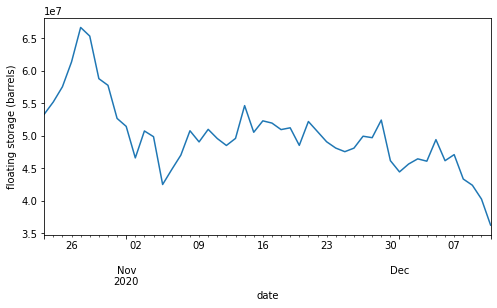

In [4]:
ax = df_floating_storage.plot(x='date',y='barrels',legend=False,figsize=(8,4))
ax.set_ylabel('floating storage (barrels)')

Let's say we now want to compare the time variation of floating storage of each category of crude. To do this, we can loop over each category and do a separate search that filters on that category only.

To start, we get the IDs of each category of crude:

In [5]:
medium_sour = [p.id for p in v.Products().search('medium-sour').to_list() if p.name=='Medium-Sour']
light_sour = [p.id for p in v.Products().search('light-sour').to_list() if p.name=='Light-Sour']
heavy_sour = [p.id for p in v.Products().search('heavy-sour').to_list() if p.name=='Heavy-Sour']
medium_sweet = [p.id for p in v.Products().search('medium-sweet').to_list() if p.name=='Medium-Sweet']
light_sweet = [p.id for p in v.Products().search('light-sweet').to_list() if p.name=='Light-Sweet']
heavy_sweet = [p.id for p in v.Products().search('heavy-sweet').to_list() if p.name=='Heavy-Sweet']

assert len(medium_sour) == 1
assert len(light_sour) == 1
assert len(heavy_sour) == 1
assert len(medium_sweet) == 1
assert len(light_sweet) == 1
assert len(heavy_sweet) == 1

To make these more convenient to work with, we make a dictionary for the ID of each category:

In [6]:
crude_dict = {
    'medium-sour': medium_sour[0],
    'light-sour': light_sour[0],
    'heavy-sour': heavy_sour[0],
    'medium-sweet': medium_sweet[0],
    'light-sweet': light_sweet[0],
    'heavy-sweet': heavy_sweet[0],
}

We then do a loop over the categories in the dictionary. For each search, we produce a DataFrame, and then add the `values` column to our `df_floating_storage` DataFrame. 

In [7]:
for category in crude_dict:
    search_result = v.CargoTimeSeries().search(
        timeseries_frequency=TS_FREQ,
        timeseries_unit=TS_UNIT,
        # filter only on one category of crude
        filter_products=crude_dict[category],
        filter_time_min=seven_weeks_ago,
        filter_time_max=now,
        # Filter for cargo in floating storage
        filter_activity="storing_state",
        # Only get floating storage that lasted longer than 21 days
        timeseries_activity_time_span_min=1000 * 60 * 60 * 24 * 14,
    )

    df_cat = search_result.to_df()
    df_floating_storage[category] = df_cat['value']

In [8]:
df_floating_storage.head()

,date,barrels,count,medium-sour,light-sour,heavy-sour,medium-sweet,light-sweet,heavy-sweet
0,2020-10-23 00:00:00+00:00,53304491,91,14332532,4601011,7293267,8883040,3490263,2882745
1,2020-10-24 00:00:00+00:00,55202620,93,16219906,4601011,7293267,8883040,3490263,2882745
2,2020-10-25 00:00:00+00:00,57537192,96,18554478,4601011,7293267,8883040,3490263,2882745
3,2020-10-26 00:00:00+00:00,61365496,99,19194792,5177106,7293267,9206921,2582243,3778060
4,2020-10-27 00:00:00+00:00,66680069,111,21153328,5177106,7044890,11727554,3848509,3778060


We now have the data we need to make a plot comparing each of these categories:

Text(0, 0.5, 'floating storage (barrels)')

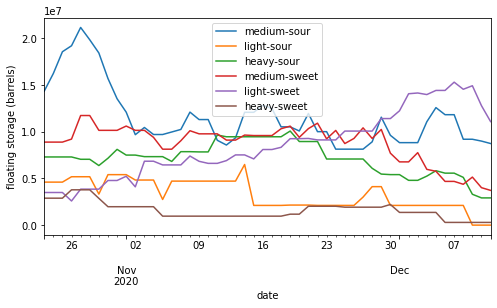

In [9]:
ax = df_floating_storage.plot(x='date',y=list(crude_dict.keys()),figsize=(8,4))
ax.set_ylabel('floating storage (barrels)')

### Exercise

Compare and plot the floating storage of crude in different geographic regions over the last 7 weeks.